<a href="https://colab.research.google.com/github/mrmc-speco/diffit-lora/blob/main/DiffiT_Image_Space_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffiT: Diffusion Vision Transformers for Image Generation

### A Pytorch Lightning [16] re-implementation of the original paper [1].
Presented by:
* Simone Scaccia
  * Email: scaccia.2045976@studenti.uniroma1.it
  * GitHub: https://github.com/simonescaccia
* Luca Zanchetta
  * Email: zanchetta.1848878@studenti.uniroma1.it
  * GitHub: https://github.com/luca-zanchetta

Official repository available at: https://github.com/luca-zanchetta/DiffiT-Implementation

## Description of the Method

Here we have provided a Pytorch Lightning re-implementation of the paper **"DiffiT: Diffusion Vision Transformers for Image Generation"** [1]. The paper proposes two different architectures: the **Image Space** architecture, which is basically a U-shaped encoder-decoder architecture, and the **Latent Space** architecture, which is another encoder-decoder architecture that makes use of a vision transformer in the middle.

The paper focuses on two main issues:
* There was no standard design pattern for using self-attention layers in denoising networks;
* There was the need for better control in capturing the time-dependence aspect in self-attention modules for denoising diffusion models.

In order to address these challenges, the paper introduces a new model called **DiffiT**: this model aims at integrating the temporal dependency into self-attention layers, and it has shown to outperform other models in tasks related to image generation. For further information, please refer to the original paper itself [1].

---
## Core block

The core block of the DiffiT model is the **DiffiT Transformer Block**, which is defined as follows:

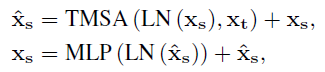

At every layer, the DiffiT Transformer block receives a set of tokens {\\(\mathbf{x}_s\\)} arranged spatially on a 2D grid; it also receives \\(\mathbf{x}_t\\), a time token representing the time step. The time token is obtained by feeding positional time embeddings to a small MLP with Swish activation function.

At this point, the authors define their **Time-Dependent Multi-Head Self-Attention (TMSA)** layer, that captures both long-rande spatial and temporal dependencies by projecting feature and time token embeddings into a shared space. In particular, time dependent queries **q**, keys **k** and values **v** in the shared space are computed by a linear projection of spatial and time embeddings:

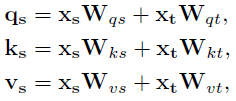

As a result, queries, keys and values are all linear functions of both time and spatial tokens, and they can adaptively modify the behavior of the attention mechanism for different time steps.

The Self-Attention is computed as follows:

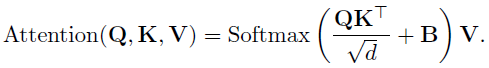

where Q = \\(\mathbf{q}_s\\), K = \\(\mathbf{k}_s\\) and V = \\(\mathbf{v}_s\\) are a stacked form of queries, keys and values in rows of a matrix; d is a scaling factor for keys K, and B corresponds to a *relative position bias*, which allows for the encoding of the information across each attention head.

---
## Image Space DiffiT Architecture

The **Image Space DiffiT Architecture** consists of a symmetrical U-shaped encoder-decoder architecture in which the contracting and expanding paths are connected to each other via skip connections at every resolution.

In particular, each resolution consists of L consecutive DiffiT blocks, containing the time-dependent self-attention modules proposed by the paper. At the beginning of each path, a convolutional layer is employed, in order to match the number of feature maps. In addition, a convolutional *upsampling* or *downsampling* layer is also used for transitioning between each resolution.

In the Image Space DiffiT Architecture, a **DiffiT ResBlock** is also defined by combining the proposed DiffiT Transformer block with a convolutional layer, by means of a residual connection:

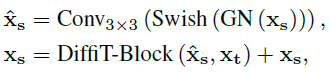

---
## Latent Space DiffiT Architecture

In the **Latent Space DiffiT Architecture**, the images are first of all encoded by the means of a variational autoencoder network; although in the paper is used a pre-trained network, here we have re-implemented it from scratch as requested.

The produced feature maps are then converted into non-overlapping patches, and projected into a new embedding space. Then, a Vision Transformer is used as the denoising network in the latent space, without upsampling or downsampling layers. the final layer of the architecture is a simple linear layer for decoding the output.

# Pytorch Code

## Dependencies and Import statements

Install all the required dependencies

In [1]:
%%capture
!pip install datasets
!pip install pytorch_lightning
!pip install torch-ema
!pip install torchmetrics[image]

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
import requests

from torchmetrics.image.fid import FrechetInceptionDistance
from scipy.stats import wasserstein_distance
from sklearn.metrics import precision_score, recall_score
from tqdm.auto import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint
from torch_ema import ExponentialMovingAverage
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from torchvision import transforms
from torchvision.transforms import Compose, Lambda, ToPILImage, Resize, CenterCrop, ToTensor
from PIL import Image

Set the device

In [ ]:
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Hyperparameters

The hyperparameters we have used for the final training; it is worth noting that we have also done several experiments, that will be reported in a subsequent section.

Since there are two models that can be used, the user is required to select the model by properly setting the MODEL variable. The strategy here is to comment the model that the user DOES NOT want to use, and to decomment the other model; notice that at least one of the two models must be selected. Given a selected model, a set of hyperparameters is automatically set; the shown values are the final values that we have employed for our best experiments.

A similar idea applies for the execution mode: the user can choose the execution mode by properly setting the variables IS_TRAIN, IS_TEST and IS_METRIC. At least one of them should be set to True.

---

In practice, once you have chosen the model and the execution mode, you can run all cells without the need of running them one by one!

In [ ]:
global MODEL
MODEL = "image-space"
# MODEL = "latent-space"

global IS_TRAIN
IS_TRAIN = True
IS_TEST = True
IS_METRIC = True


if MODEL == "latent-space":
  DATASET_NAME = "IMAGENETTE"
  DIR_WEIGHTS = "/content/drive/MyDrive/diffit/LatentWeights/"
  PATH_WEIGHTS = "/content/drive/MyDrive/diffit/LatentWeights/best_model.ckpt"

  BATCH_SIZE_TRAIN = 32 # BATCH_SIZE = 512 paper
  BATCH_SIZE_TEST = 16
  LEARNING_RATE = 0.001
  IMG_SIZE = 32

  NUM_EPOCHS = 10

  D_MODEL = 128 # D_MODEL = TOKEN_DIM = TIME_EMBEDDING_DIM = 512, paper Table 3
  N_LATENT_BLOCKS = 1
  NUM_HEADS = 2
  DROPOUT_PROB = 0.1
  D_FF = 2 * D_MODEL # paper H.2

  T = 500   # Number of (de)noising steps


elif MODEL == "image-space":
  DATASET_NAME = "CIFAR"
  DIR_WEIGHTS = "/content/drive/MyDrive/diffit/ImageSpaceWeights/"
  PATH_WEIGHTS = "/content/drive/MyDrive/diffit/ImageSpaceWeights/best_model.ckpt"

  BATCH_SIZE_TRAIN = 512 # BATCH_SIZE = 512 paper
  BATCH_SIZE_TEST = 16
  LEARNING_RATE = 0.001
  IMG_SIZE = 32

  NUM_EPOCHS = 100

  D_MODEL = 512 # D_MODEL = TOKEN_DIM = TIME_EMBEDDING_DIM = 512, paper Table 3
  NUM_HEADS = 2
  DROPOUT_PROB = 0.1
  D_FF = 2 * D_MODEL # paper H.2

  T = 500   # Number of (de)noising steps


assert PATH_WEIGHTS != "" or PATH_WEIGHTS != None, "[ERROR] You should configure a path where to save/load weights of the model."
assert MODEL == "image-space" or MODEL == "latent-space", "[ERROR] MODEL should be either 'image-space' or 'latent-space'."
assert IS_TRAIN or IS_TEST or IS_METRIC, "[ERROR] EXECUTION MODE should be either 'TRAIN', 'TEST' or 'METRICS'."

In [ ]:
global train_losses
global test_losses
train_losses = []
test_losses = []

## Model Architecture

The model proposed in the original paper (see [1]) can be implemented in two different ways. Indeed, there is a first architecture called **Image Space DiffiT Architecture**, which is constituted by a U-shaped network, and a second architecture called **Latent Space DiffiT Architecture**.

Both of these architectures have been implemented in what follows. In particular, we start from the core block of both the models: the *DiffiT Transformer Block*. Then, we proceed by implementing the Latent Space model and finally the Image Space model.

### DiffiT Transformer Block

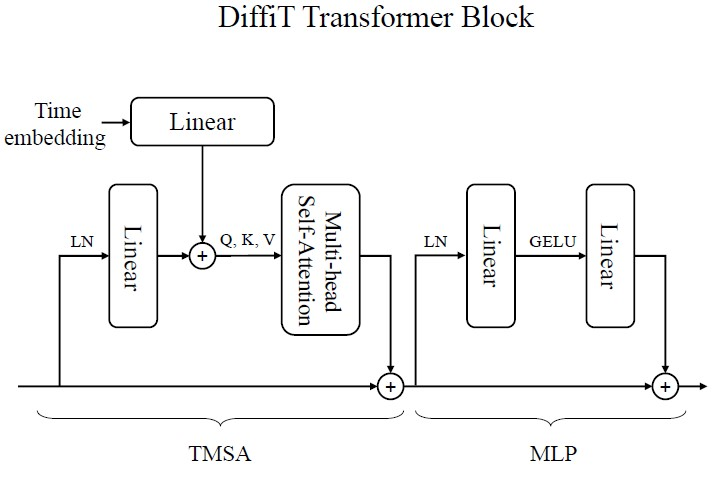

Execute the following 4 cells to implement the DiffiT Transformer Block.

In [ ]:
# Taken from [3]
def causal_mask(size):
  mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int).to(device)
  return mask == 0

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))    # Multiplies
        self.bias = nn.Parameter(torch.zeros(1))    # Added

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class MLP(nn.Module):
  def __init__(self, img_size: int, d_ff: int): # d_ff: feed forward dimension
    super().__init__()
    self.linear_1 = nn.Linear(img_size, d_ff)
    self.gelu = nn.GELU()
    self.linear_2 = nn.Linear(d_ff, img_size)

  def forward(self, x):
    out_linear_1 = self.linear_1(x)
    out_gelu = self.gelu(out_linear_1)
    out_linear_2 = self.linear_2(out_gelu)
    return out_linear_2


class TMSA(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, img_size: int):    # d_model = space_embedding_size = time_embedding_size
    super().__init__()
    self.space_embedding_size = d_model
    self.time_embedding_size = d_model
    self.d_model = d_model
    self.num_heads = num_heads
    self.seq_len = img_size * img_size
    self.img_size = img_size
    self.d = d_model // num_heads
    self.mask = causal_mask(self.seq_len)
    assert d_model % num_heads == 0, 'space_embedding_size is not divisible by num_heads!'

    # Linear projections for xs
    self.Wqs = nn.Linear(d_model, d_model, bias = False) # y = x*A^T + b  => A^T = (space_embedding_size, space_embedding_size), Wqs = A^T
    self.Wks = nn.Linear(d_model, d_model, bias = False)
    self.Wvs = nn.Linear(d_model, d_model, bias = False)

    # Linear projections for xt
    self.Wqt = nn.Linear(d_model, d_model, bias = False)
    self.Wkt = nn.Linear(d_model, d_model, bias = False)
    self.Wvt = nn.Linear(d_model, d_model, bias = False)

    self.WK = nn.Linear(self.d, self.seq_len, bias = False) # y = x*A^T + b, A^T = w^K

    self.wo = nn.Linear(d_model, d_model, bias=False) # Wo

    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def compute_attention_scores(query, key, value, wK, mask, dropout: nn.Dropout):
    d = query.shape[-1]

    attention_scores = ((query @ key.transpose(-2, -1) + wK(query)) / math.sqrt(d))

    # Apply mask if required
    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)

    # Apply softmax
    attention_scores = F.softmax(attention_scores, dim = -1)

    # Apply dropout if required
    if dropout is not None:
      attention_scores = dropout(attention_scores)

    # return here
    return attention_scores @ value # ,attention_scores for visualization

  def forward(self, xs, xt):
    xs = xs.view(xs.shape[0], self.seq_len, xs.shape[1])

    # Space query, key and value
    query_s = self.Wqs(xs)      # query.shape: (batch, seq_len, d_model)
    key_s = self.Wks(xs)
    value_s = self.Wvs(xs)

    qs_1 = query_s.view(query_s.shape[0], query_s.shape[1], self.num_heads, self.d).transpose(1, 2)
    ks_1 = key_s.view(key_s.shape[0], key_s.shape[1], self.num_heads, self.d).transpose(1, 2)
    vs_1 = value_s.view(value_s.shape[0], value_s.shape[1], self.num_heads, self.d).transpose(1, 2)

    # Temporal query, key and value
    query_t = self.Wqt(xt)
    key_t = self.Wkt(xt)
    value_t = self.Wvt(xt)

    qt_1 = query_t.view(query_t.shape[0], -1, self.num_heads, self.d).transpose(1, 2)
    kt_1 = key_t.view(key_t.shape[0], -1, self.num_heads, self.d).transpose(1, 2)
    vt_1 = value_t.view(value_t.shape[0], -1, self.num_heads, self.d).transpose(1, 2)

    # Concatenation
    qs = qs_1 + qt_1
    ks = ks_1 + kt_1
    vs = vs_1 + vt_1

    # Compute attention scores
    h = self.compute_attention_scores(qs, ks, vs, self.WK, self.mask, self.dropout)

    # Combine all the heads together
    h = h.transpose(1, 2).contiguous().view(h.shape[0], -1, self.num_heads * self.d)

    output = self.wo(h)
    output = output.view(h.shape[0], h.shape[2], int(math.sqrt(h.shape[1])), -1)

    # Multiply by Wo
    return output


class DiffiTBlock(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, d_ff: int, img_size: int, label_size: int = None):
    super().__init__()
    self.ln = LayerNormalization()
    self.tmsa = TMSA(d_model, num_heads, dropout, img_size)
    self.mlp = MLP(img_size, d_ff)
    self.time_embedding = TimeEmbedding(d_model, img_size*img_size)

    # Only for latent model
    if label_size is not None:
      self.label_size = label_size
      self.label_embedding = LabelEmbedding(label_size, d_model)

  def forward(self, xs, t, l=None):
    xt = self.time_embedding(t)
    tmsa_comb = xt

    if l is not None:
      tmsa_comb += self.label_embedding(l)

    xs1 = self.tmsa(self.ln(xs), tmsa_comb) + xs
    xs2 = self.mlp(self.ln(xs1)) + xs1

    return xs2

In [ ]:
class Tokenizer(nn.Module):
  def __init__(self, out_channels: int, in_channels = 3):
    super().__init__()
    self.conv3x3 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)

  def forward(self, x):
    return self.conv3x3(x)


class Head(nn.Module):
  def __init__(self, in_channels: int, out_channels = 3):
    super().__init__()
    self.group_norm = nn.GroupNorm(num_groups=in_channels//4, num_channels=in_channels)
    self.conv3x3 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)

  def forward(self, x):
    return self.conv3x3(self.group_norm(x))


# From paragraph 3.2 of the DiffiT paper; implementation from the HuggingFace blog (https://huggingface.co/blog/annotated-diffusion)
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
      super().__init__()
      self.dim = dim

    def forward(self, time):
      device = time.device
      half_dim = self.dim // 2

      embeddings = math.log(10000) / (half_dim - 1)
      embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
      embeddings = time[:, None] * embeddings[None, :]
      embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
      return embeddings


# From paragraph 3.2 of the DiffiT paper
class TimeEmbedding(nn.Module):
  def __init__(self, d_model: int, seq_len: int):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model

    self.time_embedding_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(seq_len),
        nn.Linear(seq_len, d_model),
        nn.SiLU(),
        nn.Linear(d_model, d_model)
    )

  def forward(self, time_steps):
    return self.time_embedding_mlp(time_steps) # (batch, seq_len, d_model)


class DiffiTResBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, d_model: int, num_heads: int, dropout: float, d_ff: int, img_size: int, device, label_size: int = None):
    super().__init__()
    self.device = device
    self.seq_len = img_size * img_size

    self.conv3x3 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
    self.swish = nn.SiLU()
    self.group_norm = nn.GroupNorm(num_groups = in_channels//4, num_channels = in_channels)
    self.diffit_block = DiffiTBlock(out_channels, num_heads, dropout, d_ff, img_size, label_size)

  def forward(self, xs, t, l=None):
    xs_1 = self.conv3x3(self.swish(self.group_norm(xs)))
    xs = xs + self.diffit_block(xs_1, t, l)

    return xs


# From page 14 of the DiffiT paper
class Downsample(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 2, padding: int = 1):
    super().__init__()
    self.conv = nn.Conv2d(
        in_channels = in_channels,
        out_channels = out_channels,
        kernel_size = kernel_size,
        stride = stride,
        padding = padding
    )

  def forward(self, x):
    return self.conv(x)


class Upsample(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 2, padding: int = 1, output_padding: int = 1):
    super().__init__()
    self.conv = nn.ConvTranspose2d(
        in_channels = in_channels,
        out_channels = out_channels,
        kernel_size = kernel_size,
        stride = stride,
        padding = padding,
        output_padding = output_padding
    )

  def forward(self, x):
    return self.conv(x)


class ResBlockGroup(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, d_ff: int, L: int, in_channels: int, out_channels: int, img_size: int, device, label_size: int = None):
    super().__init__()
    self.L = L
    self.diffit_res_block = DiffiTResBlock(in_channels, out_channels, d_model, num_heads, dropout, d_ff, img_size, device, label_size)

  def forward(self, x, t, l=None):
    for _ in range(self.L):
      x = self.diffit_res_block(x, t, l)
    return x

The implementation of the following functions has been taken from [9]

In [ ]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# x_t-1 -> x_t
def q_sample(x_start, t, noise):
  # define beta schedule
  # betas = cosine_beta_schedule(timesteps=T)
  betas = linear_beta_schedule(timesteps=T)

  # define alphas
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

  # calculations for diffusion q(x_t | x_{t-1}) and others
  sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
  sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x_start.shape
  )

  return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_start, t, l=None):
  # get Gaussian noise
  noise = torch.randn_like(x_start)

  # apply the noise to the image
  x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
  predicted_noise = denoise_model(x_noisy, t, l)

  # return F.mse_loss(noise, predicted_noise)
  return F.smooth_l1_loss(noise, predicted_noise)

@torch.no_grad()
def p_sample(model, x, t, t_index):
    # define beta schedule
    # betas = cosine_beta_schedule(timesteps=T)
    betas = linear_beta_schedule(timesteps=T)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, None) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

### Latent Space DiffiT Architecture

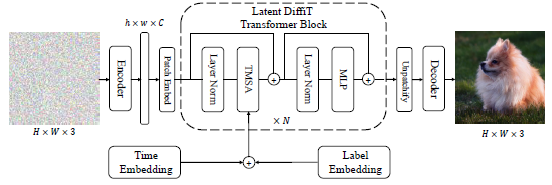

Execute the following cell to implement the Latent Space DiffiT Architecture.

In [ ]:
class DiffiTEncoder(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, d_ff: int, img_size: int, device, label_size: int, L1: int = 4, L2: int = 4, L3: int = 4, L4: int = 4):
    super().__init__()
    d_model_2 = d_model*2

    self.tokenizer = Tokenizer(out_channels=d_model)
    self.diffit_res_block_group_1 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L1, in_channels=d_model, out_channels=d_model, img_size=img_size, device=device, label_size=label_size)
    self.downsample_1 = Downsample(in_channels=d_model, out_channels=d_model_2)
    self.diffit_res_block_group_2 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L2, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size//2, device=device, label_size=label_size)
    self.downsample_2 = Downsample(in_channels=d_model_2, out_channels=d_model_2)
    self.diffit_res_block_group_3 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L3, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size//4, device=device, label_size=label_size)
    self.downsample_3 = Downsample(in_channels=d_model_2, out_channels=d_model_2)
    self.diffit_res_block_group_4 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L4, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size//8, device=device, label_size=label_size)

  def forward(self, x, t, l):
    out_1 = self.downsample_1(self.diffit_res_block_group_1(self.tokenizer(x), t, l))
    out_2 = self.downsample_2(self.diffit_res_block_group_2(out_1, t, l))
    out_3 = self.diffit_res_block_group_4(self.downsample_3(self.diffit_res_block_group_3(out_2, t, l)), t, l)
    return out_3


class DiffiTDecoder(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, d_ff: int, img_size: int, device, label_size: int, L1: int = 4, L2: int = 4, L3: int = 4):
    super().__init__()
    d_model_2 = d_model//2

    self.upsample_1 = Upsample(in_channels=d_model, out_channels=d_model)
    self.diffit_res_block_group_3 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L3, in_channels=d_model, out_channels=d_model, img_size=img_size//4, device=device, label_size=label_size)
    self.upsample_2 = Upsample(in_channels=d_model, out_channels=d_model)
    self.diffit_res_block_group_2 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L2, in_channels=d_model, out_channels=d_model, img_size=img_size//2, device=device, label_size=label_size)
    self.upsample_3 = Upsample(in_channels=d_model, out_channels=d_model_2)
    self.diffit_res_block_group_1 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L1, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size, device=device, label_size=label_size)
    self.head = Head(in_channels=d_model_2)

  def forward(self, x, t, l):
    out_1 = self.upsample_1(x)
    out_2 = self.upsample_2(self.diffit_res_block_group_3(out_1, t, l))
    out_3 = self.diffit_res_block_group_1(self.upsample_3(self.diffit_res_block_group_2(out_2, t, l)), t, l)
    return self.head(out_3)


class LatentDiffiTTransformerBlock(nn.Module):
  def __init__(self, d_model: int, num_heads: int, dropout: float, d_ff: int, N: int, img_size: int, label_size: int):
    super().__init__()
    self.N = N
    self.diffit_block = DiffiTBlock(d_model, num_heads, dropout, d_ff, img_size=img_size, label_size=label_size)

  def forward(self, xs, t, l):
    for _ in range(self.N):
      xs = self.diffit_block(xs, t, l)
    return xs


class LabelEmbedding(nn.Module):
  def __init__(self, label_size: int, d_model: int):
    super().__init__()
    self.label_size = label_size

    self.embedding_layer = nn.Embedding(label_size, d_model)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, l):
    return self.linear_layer(self.embedding_layer(l))


# Adapted from [6]
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
      super().__init__()
      assert (img_size % patch_size == 0), 'img_size is not divisible by patch_size!'

      self.proj = nn.Conv2d(
          in_channels = embed_dim,
          out_channels = embed_dim,
          kernel_size = patch_size,         # The receptive field will contain exactly one patch at a time
          stride = patch_size,              # No overlapping between patches; each patch is processed in isolation
      )

    def forward(self, x):
      # x.shape = (n_samples, in_channels, img_size, img_size)
      x = self.proj(x)   # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
      return x


# Adapted from [6]
class Unpatch(nn.Module):
  def __init__(self, img_size, patch_size, embed_dim):
    super().__init__()
    assert (img_size % patch_size == 0), 'img_size is not divisible by patch_size!'

    self.proj = nn.ConvTranspose2d(
        in_channels = embed_dim,
        out_channels = embed_dim,
        kernel_size = patch_size,
        stride = patch_size
    )

  def forward(self, x):
    # x.shape = (n_samples, n_patches, embed_dim)
    x = self.proj(x)  # (n_samples, out_channels, img_size, img_size)
    return x


class LatentDiffiTNetwork(pl.LightningModule):
  def __init__(self,
              N_latent_blocks: int,
              img_size: int,
              d_model: int,
              num_heads: int,
              dropout: float,
              d_ff: int,
              learning_rate,
              denoising_steps: int,
              device,
              label_size: int,
              stride = 2,
              patch_size = 2):
    super().__init__()
    self.label_size = label_size

    self.image_size_input_latent_block = (img_size // stride**3) // patch_size    # stride = 2 defined by the paper
    self.seq_len_input_latent_block = self.image_size_input_latent_block * self.image_size_input_latent_block
    self.learning_rate = learning_rate
    self.denoising_steps = denoising_steps

    self.encoder = DiffiTEncoder(d_model, num_heads, dropout, d_ff, img_size=img_size, device=device, label_size=label_size)
    self.patch_embedding = PatchEmbedding(img_size, patch_size, d_model*2)
    self.latent_block = LatentDiffiTTransformerBlock(d_model*2, num_heads, dropout, d_ff, N_latent_blocks, img_size=self.image_size_input_latent_block, label_size=label_size)
    self.unpatchify = Unpatch(img_size, patch_size, d_model*2)
    self.decoder = DiffiTDecoder(d_model*2, num_heads, dropout, d_ff, img_size=img_size, device=device, label_size=label_size)
    self.ema = ExponentialMovingAverage(self.parameters(), decay=0.999)

  def forward(self, xs, t, l):
    # image --> encoder
    encoder_output = self.encoder(xs, t, l)
    # encoder --> patch embedding
    patch_embedding_output = self.patch_embedding(encoder_output)
    # patch embedding --> latent block
    latent_block_output = self.latent_block(patch_embedding_output, t, l)
    # latent block --> unpatchify
    unpatchify_output = self.unpatchify(latent_block_output)
    # unpatchify --> decoder
    decoder_output = self.decoder(unpatchify_output, t, l)
    # decoder --> image
    return decoder_output

  def training_step(self, batch, batch_idx):
    # Sample t uniformally for every example in the batch
    t = torch.randint(0, self.denoising_steps, (len(batch),), device=self.device).long()
    # Similar concept as t for label embeddings
    l = torch.randint(0, self.label_size, (len(batch),), device=self.device).long()
    # l = None

    # Compute loss
    loss = p_losses(self, batch, t, l)

    if batch_idx % 25 == 0:
      print(f"loss: {loss:.2f}")
      train_losses.append(loss.cpu().detach().numpy())

    self.log('train_loss', loss)
    return loss

  def test_step(self, batch, batch_idx):
    # Sample t uniformally for every example in the batch
    t = torch.randint(0, self.denoising_steps, (len(batch),), device=self.device).long()
    # Similar concept as t for label embeddings
    l = torch.randint(0, self.label_size, (len(batch),), device=self.device).long()
    # l = None

    # Compute loss
    loss = p_losses(self, batch, t, l)
    test_losses.append(loss.cpu().detach().numpy())

    self.log('test_loss', loss)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  # implementation of exponential moving average (EMA)
  def optimizer_step(self, *args, **kwargs):
    super().optimizer_step(*args, **kwargs)
    self.ema.to(device)
    self.ema.update(self.parameters())

### Image Space DiffiT Architecture

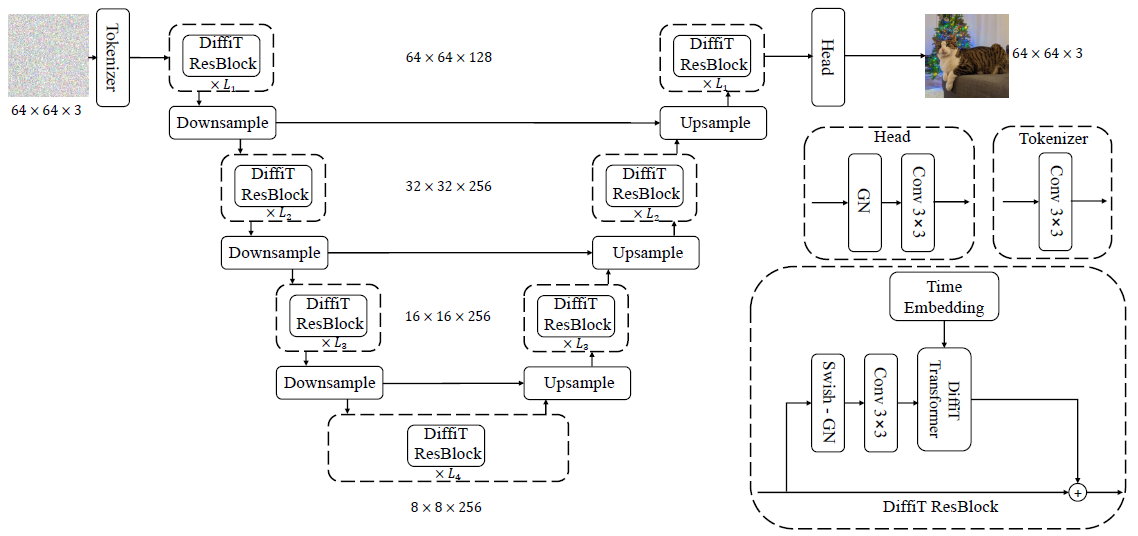

Execute the following cell to implement the Image Space DiffiT Architecture.

In [ ]:
class UShapedNetwork(pl.LightningModule):
  def __init__(
      self,
      learning_rate: float,
      d_model: int,
      num_heads: int,
      dropout: float,
      d_ff: int,
      img_size: int,
      device,
      denoising_steps: int,
      L1: int = 2,
      L2: int = 2,
      L3: int = 2,
      L4: int = 2
    ):
    super().__init__()
    d_model_2 = d_model*2

    self.learning_rate = learning_rate
    self.denoising_steps = denoising_steps

    self.diffit_res_block_group_1 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L1, in_channels=d_model, out_channels=d_model, img_size=img_size, device=device)
    self.diffit_res_block_group_2 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L2, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size//2, device=device)
    self.diffit_res_block_group_3 = ResBlockGroup(d_model, num_heads, dropout, d_ff, L3, in_channels=d_model_2, out_channels=d_model_2, img_size=img_size//4, device=device)

    self.downsample_1 = Downsample(in_channels=d_model, out_channels=d_model_2)
    self.downsample_2 = Downsample(in_channels=d_model_2, out_channels=d_model_2)

    self.upsample_1 = Upsample(in_channels=d_model_2, out_channels=d_model_2)
    self.upsample_2 = Upsample(in_channels=d_model_2, out_channels=d_model)

    self.tokenizer = Tokenizer(out_channels=d_model)
    self.head = Head(in_channels=d_model)

  def uShape(self, xs, t):
    output_downsample_1 = self.downsample_1(self.diffit_res_block_group_1(xs, t))
    output_downsample_2 = self.downsample_2(self.diffit_res_block_group_2(output_downsample_1, t))
    uLeft = output_downsample_2

    uCenter = self.diffit_res_block_group_3(uLeft, t)

    input_upsample_1 = uCenter + uLeft
    input_upsample_2 = self.diffit_res_block_group_2(self.upsample_1(input_upsample_1), t) + output_downsample_1
    uRight = self.diffit_res_block_group_1(self.upsample_2(input_upsample_2), t)

    return uRight

  def forward(self, xs, t, l=None):
    return self.head(self.uShape(self.tokenizer(xs), t))

  def training_step(self, batch, batch_idx):
    # Sample t uniformally for every example in the batch
    t = torch.randint(0, self.denoising_steps, (len(batch),), device=self.device).long()

    # Compute loss
    loss = p_losses(self, batch, t)

    if batch_idx % 25 == 0:
      print(f"loss: {loss:.2f}")
      train_losses.append(loss.cpu().detach().numpy())

    self.log('train_loss', loss)
    return loss

  def test_step(self, batch, batch_idx):
    # Sample t uniformally for every example in the batch
    t = torch.randint(0, self.denoising_steps, (len(batch),), device=self.device).long()

    # Compute loss
    loss = p_losses(self, batch, t)
    test_losses.append(loss.cpu().detach().numpy())

    self.log('test_loss', loss)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

### Dataset

Execute the following 3 cells to be able to get the used datasets.

In [ ]:
def get_ds(ds_name: str):
  match ds_name:
    case "CIFAR":
      return get_cifar_ds()
    case "IMAGENETTE":
      return get_imagenette_ds()
    case _:
      return None

#### Imagenette dataset [14]

In [ ]:
def get_imagenette_ds():
  dataset = load_dataset('frgfm/imagenette', '160px')

  train = dataset['train']
  test = dataset['validation']

  trans = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor(),
  ])

  train_tensor = []
  for image in train:
    image_tensor = trans(image['image'])
    if image_tensor.shape[0] == 3:
      train_tensor.append(image_tensor)

  test_tensor = []
  for image in test:
    image_tensor = trans(image['image'])
    if image_tensor.shape[0] == 3:
      test_tensor.append(image_tensor)

  return train_tensor, test_tensor

#### CIFAR_10 dataset [15]

In [ ]:
def get_cifar_ds():
  dataset = load_dataset('cifar10')

  train = dataset['train']
  test = dataset['test']

  train_tensor = []
  trans = transforms.ToTensor()
  for image in train:
    image_tensor = trans(image['img'])
    train_tensor.append(image_tensor)

  test_tensor = []
  for image in test:
    image_tensor = trans(image['img'])
    test_tensor.append(image_tensor)

  return train_tensor, test_tensor

### Train or Test the model

For training, a new instance of the model is created and it is trained from scratch. For testing and/or metrics evaluation, a model must have been pre-trained from scratch.

Execute the following 3 cells to execute the training/testing procedure.

In [ ]:
train_ds, test_ds = get_ds(ds_name = DATASET_NAME)

In [ ]:
# Create PyTorch DataLoader
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=DIR_WEIGHTS,
    filename='best_model',
    monitor='train_loss',
    mode='min',
    verbose=True
)

In [ ]:
# Initialize DiffiT model
if MODEL == "image-space":
  if IS_TRAIN:
    diffit_model = UShapedNetwork(
        learning_rate = LEARNING_RATE,
        d_model = D_MODEL,
        num_heads = NUM_HEADS,
        dropout = DROPOUT_PROB,
        d_ff = D_FF,
        img_size = IMG_SIZE,
        device = device,
        denoising_steps = T
    )
  elif IS_TEST or IS_METRIC:
    diffit_model = UShapedNetwork.load_from_checkpoint(
        PATH_WEIGHTS,
        learning_rate = LEARNING_RATE,
        d_model = D_MODEL,
        num_heads = NUM_HEADS,
        dropout = DROPOUT_PROB,
        d_ff = D_FF,
        img_size = IMG_SIZE,
        device = device,
        denoising_steps = T
    )

elif MODEL == "latent-space":
  if IS_TRAIN:
    diffit_model = LatentDiffiTNetwork(
        N_LATENT_BLOCKS,
        IMG_SIZE,
        D_MODEL,
        NUM_HEADS,
        DROPOUT_PROB,
        D_FF,
        LEARNING_RATE,
        T,
        device=device,
        label_size = len(train_ds)
    )
  elif IS_TEST or IS_METRIC:
    diffit_model = LatentDiffiTNetwork.load_from_checkpoint(
        PATH_WEIGHTS,
        N_latent_blocks = N_LATENT_BLOCKS,
        img_size = IMG_SIZE,
        d_model = D_MODEL,
        num_heads = NUM_HEADS,
        dropout = DROPOUT_PROB,
        d_ff = D_FF,
        learning_rate = LEARNING_RATE,
        denoising_steps = T,
        device = device,
        label_size = len(train_ds)
    )

diffit_model = diffit_model.to(device)


if IS_TRAIN:
  # Train the model
  trainer = pl.Trainer(max_epochs=NUM_EPOCHS, accelerator="auto", callbacks=[checkpoint_callback], log_every_n_steps=1)
  trainer.fit(diffit_model, train_dataloader)
if IS_TEST:
  # Test the model
  trainer = pl.Trainer(max_epochs=1, accelerator="auto", callbacks=[checkpoint_callback])
  trainer.test(diffit_model, test_dataloader)

### Noisification

Here, we show the noisification process employed in the forward diffusion process [9] on an image of the CIFAR10 dataset [15]. Just execute the following cell.

In [ ]:
import numpy as np
from torchvision.transforms import Compose, Lambda, ToPILImage, Resize, CenterCrop, ToTensor
from PIL import Image
import requests

def show_images_grid(images_list):
  # Set the number of images per row
  images_per_row = 5
  image_size = 2  # Adjust this value to control the size of the images

  # Calculate the number of rows needed
  num_rows = len(images_list) // images_per_row
  if len(images_list) % images_per_row != 0:
      num_rows += 1


  # Plotting all images with 10 images per row
  fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * image_size, num_rows * image_size))

  # Flatten the axes array if it's a multi-row layout
  axes = axes.flatten()

  for i, img in enumerate(images_list):
      img_tensor = torch.tensor(img)
      ax = axes[i]
      ax.imshow(transforms.ToPILImage()(img_tensor).convert("RGB"))
      ax.axis('off')

  # Remove any empty subplots
  for i in range(len(images_list), len(axes)):
      fig.delaxes(axes[i])

  plt.tight_layout()
  plt.show()

def get_noisy_image(x_start, t):
  # get Gaussian noise
  noise = torch.randn_like(x_start)
  # add noise
  x_noisy = q_sample(x_start, t=t, noise=noise).cpu().detach().numpy()
  return x_noisy

x_start = train_ds[0]
image_size = 32

samples_to_print = []
time_steps = list(range(0, T, 50))
time_steps.append(T-1)
for t in time_steps:
  noisy_image = get_noisy_image(x_start, torch.tensor([t]))
  samples_to_print.append(noisy_image)
show_images_grid(samples_to_print)

### Metrics Evaluation

In this section, we evaluate the model based on the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance), as done in the original paper [1]. Just execute the following two cells.

In [ ]:
import random
# Create dataset batches
def get_real_features(dataset, batch_size):
  items = random.sample(dataset, batch_size)
  real_features = torch.stack(items)
  return real_features

In [ ]:
if IS_METRIC:
  channels = 3
  random_index = 5
  batch_size_fid = 128

  # sample BATCH_SIZE_TRAIN images
  samples = sample(diffit_model.to(device), image_size=IMG_SIZE, batch_size=batch_size_fid, channels=channels)

In [ ]:
if IS_METRIC:
  real_features = get_real_features(train_ds, batch_size_fid)
  generated_features = torch.tensor(samples[-1])

  # Calculate FID
  fid = FrechetInceptionDistance(feature=64, normalize=True)

  fid.update(generated_features, real=False)
  fid.update(real_features, real=True)

  fid_score = fid.compute()

  print(f'FID Score: {fid_score}\n')

In [ ]:
if IS_METRIC:
  samples_to_print = []
  time_steps = list(range(0, T, 50))
  time_steps.append(T-1)
  for t in time_steps:
    samples_to_print.append(samples[t][0])
  show_images_grid(samples_to_print)

In [ ]:
if IS_METRIC:
  show_images_grid(samples[-1])

# Obtained Results

Here is a summary of the results we have obtained throughout all of our experiments.

In [ ]:
# Create a subplot with 1 row and 2 columns
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.plot(test_losses)
plt.title('Test loss')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

## Image Space DiffiT Architecture

The DiffiT architecture for image space is trained on CIFAR-10 [15] and is smaller than the latent DiffiT model.
During training, we discovered that the image space architecture requires computational power not available in Google Colab. We tried to optimize results by adjusting some hyperparameters. We made some changes to the model.

Specifically, we reduced the number of heads from 16 to 2 and the MLP ratio in the DiffiT block from 4 to 2. Time constraints are crucial, and the paper model was trained for a total of 200000 epochs, utilizing 8 NVIDIA A100 GPUs with a batch size of 512. Our training, on the other hand, used a batch size of 64 and lasted for 3 epochs on a single T4 GPU provided by Colab.

Even though the big difference between the hardware and the time constraints, we have reached a respectable result. Indeed our model can generate images that have some similarity with the images in the dataset and better are a lot different from starting pure noise images.

Mathematically speaking, we have used the FID score to evaluate our model. However, this practice posed a challenge since in order to make a fair comparison, we needed to evaluate the entire training dataset, which contained 50,000 images. Additionally, the FID score requires the number of generated images to be equal to the number of real images, meaning that we needed to generate 50,000 samples. Due to our constraints, we evaluated the FID score on a batch of 128 images, resulting in a score between 4 and 5 instead of the expected score of 1.95 as mentioned in the paper DiffiT.

The two key improvements in our model enable us to achieve a high score with minimal epochs, even starting from a score of 50 which is equivalent to pure noise:
* torch.nn.SmoothL1Loss instead of torch.nn.MSELoss as a loss function
* linear_beta_schedule instead of cosine_beta_schedule

Here are some of the top images created by our model:

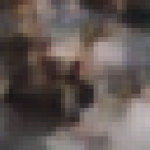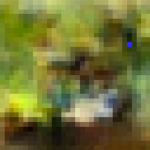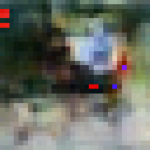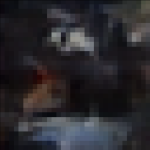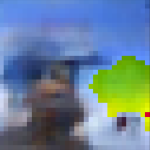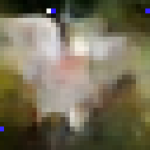

Here we show a plot of the train loss and the test loss of our model:

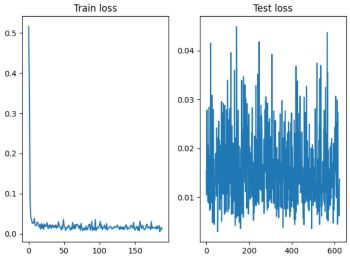

---

## Latent Space DiffiT Architecture

The DiffiT architecture for the latent space has been trained on Imagenette [14], a reduced version of the original ImageNet dataset. During training, we discovered that the latent space architecture requires computational power not available in Google Colab; so, we tried to optimize results by adjusting some hyperparameters and by making some changes to the model, as in the previous case.

In particular, we have reduced the batch size from 512 to 32; we have reduced the d_model from 512 to 128; we have used only one DiffiT Latent block and only 2 heads for the TMSA module. We have also adjusted the MLP ratio as in the previous case.

The training of this model lasted for 10 epochs under the above mentioned conditions; however, the performance was not so good as in the previous case. Indeed, the model generates images that resemble pure noise; we speculate that this is due to Google Colab constraints, and that the model would be able to reach respectable results if trained for more epochs and with a more complex structure.

Even in the case of the Latent DiffiT model, we have used the FID score in order to evaluate its performance. Since it generates what seems to be pure noise, we have obviously reached a high FID score; the best was about 49,8. Even though we made the same improvements as in the case of the Image Space model (i.e. the different loss and the linear beta schedule for the noisification process), the performance did not increase.

As an experiment, we have also tried to remove the label embedding layer, since we were expecting this layer to introduce even more noise in the training; however, we pointed out that in this case, the performance of the model actually decreases. Therefore, we have decided to keep the label embedding layer as in the original paper.

Here we show a plot of the train loss and the test loss of our model:

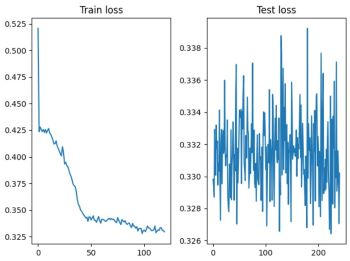

# References

Here is a list of references we have used for coding the overall notebook. Please notice that we have not used any reference to the original implementation code of the DiffiT paper; that's mainly due to the absence of any publication in the original GitHub repository at the time of writing (that, in any case, should be available [here](https://github.com/NVlabs/DiffiT)).

In what follows, the keyword **[Paper]** means that we have used the entire paper as a reference, without relying on any provided code; on the other hand, the keyword **[Inspiration]** means that we had a look at the code available at the provided reference in order to write some of our code. We have tried to avoid as much as possible copy-pasting other code, except for the cases of tutorials (especially HuggingFace🤗 ones). Finally, the keyword **[Dataset]** means that we have used the dataset provided by the cited source.

---

[1] [Paper] [DiffiT: Diffusion Vision Transformers for Image Generation](https://doi.org/10.48550/arXiv.2312.02139)

[2] [Paper] [Attention Is All You Need](https://doi.org/10.48550/arXiv.1706.03762)

[3] [Inspiration] [Transformer implementation](https://github.com/hkproj/pytorch-transformer)

[4] [Paper] [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://doi.org/10.48550/arXiv.2010.11929)

[5] [Inspiration] [Vision Transformer implementation](https://github.com/jankrepl/mildlyoverfitted/tree/master/github_adventures/vision_transformer)

[6] [Inspiration] [Patch Embeddings implementation](https://github.com/huggingface/pytorch-image-models)

[7] [Paper] [Denoising Diffusion Probabilistic Models](https://doi.org/10.48550/arXiv.2006.11239)

[8] [Inspiration] [Diffusion model implementation](https://github.com/hkproj/pytorch-ddpm)

[9] [Inspiration] [Annotated Diffusion Model implementation](https://huggingface.co/blog/annotated-diffusion)

[10] [Paper] [Self-Attention with Relative Position Representations](https://doi.org/10.48550/arXiv.1803.02155)

[11] [Paper] [Group Normalization](https://doi.org/10.48550/arXiv.1803.08494)

[12] [Inspiration] Code and hints provided by [ChatGPT](https://chat.openai.com/)

[13] [Inspiration] Code and hints provided by [PopAI](https://www.popai.pro/)

[14] [Dataset] [Imagenette dataset](https://huggingface.co/datasets/frgfm/imagenette)

[15] [Dataset] [CIFAR10 dataset](https://huggingface.co/datasets/cifar10)

[16] [Inspiration] [Pytorch Lightning docs](https://lightning.ai/docs)